In [21]:
import sys
import numpy as np
from utils import plot_2d_pso, plot_3d_pso
import matplotlib.pyplot as plt
%matplotlib inline

Objective of Particle Swarm Optimizer <br>
It is a fast and cheap method that can also be parallelized (possible w/ GPU?) <br>
PSO does not require problem to be differentiable <br> <br>

PSO was inspired to be like a flock of birds or a school of fish <br>
Think of it this way: <br>
There are a lot of birds in a valley and there is only food in one place in this valley. <br>
None of the birds know where the food is but they know how far away they are from the food. <br>


## Example Software

In this example, we will use f(x,y) = x^2 + (y+1)^2 - 5cos(1.5x+1.5) - 3cos(2x-1.5) <br>
Objective: minimize f given x and y

In [22]:
class PSO:
    def __init__(self, particles, velocities, fitness_function, \
                 w=0.8, c_1=1, c_2=1, max_iter=100, auto_coef=True):
        
        '''
            defining all of the variables involved in a PSO
        '''
        
        self.particles = particles
        self.velocities = velocities
        self.fitness_function = fitness_function
        
        self.N = len(self.particles)
        self.w = w
        self.c_1 = c_1
        self.c_2 = c_2
        self.auto_coef = auto_coef
        self.max_iter = max_iter
        
        self.p_bests = self.particles
        self.p_bests_values = self.fitness_function(self.particles)
        
        self.g_best = self.p_bests[0]
        self.g_best_value = self.p_bests_values[0]
        self.update_bests()
        
        self.iter = 0
        self.is_running = True
        self.update_coef()
        
    def __str__(self):
        return f'[{self.iter}/{self.max_iter}] $w$: {self.w:.3f} - $c_1$: {self.c_1:.3f} - $c_2$:{self.c_2:.3f}'
    
    def next(self):
        if self.iter > 0:
            #each iteration, move particle, update best, and update parameters
            self.move_particles()
            self.update_bests()
            self.update_coef()
        self.iter+=1
        self.is_running = self.is_running and self.iter < self.max_iter
        return self.is_running
    
    def update_coef(self):
        if self.auto_coef:
            t = self.iter
            n = self.max_iter
            #auto hyperparameter tuning
            self.w = (0.4/n**2) * (t-n) ** 2 + 0.4
            self.c_1 = -3 * t / n + 3.5
            self.c_2 = 3 * t / n + 0.5
    
    def move_particles(self):
        #incorporate intertia
        new_velocities = self.w * self.velocities
        #add cognitive component
        r_1 = np.random.random(self.N)
        r_1 = np.tile(r_1[:,None], (1,2))
        new_velocities += self.c_1 * r_1 * (self.p_bests - self.particles)
        #add social component
        r_2 = np.random.random(self.N)
        r_2 = np.tile(r_2[:,None], (1,2))
        g_best = np.tile(self.g_best[None], (self.N,1))
        new_velocities += self.c_2 * r_2 * (g_best - self.particles)
        
        self.is_running = np.sum(self.velocities - new_velocities) != 0
        
        #update positions and velocities
        self.velocities = new_velocities
        self.particles = self.particles + new_velocities
    
    def update_bests(self):
        fits = self.fitness_function(self.particles)
        for i in range(len(self.particles)):
            #update best personal values
            if fits[i] < self.p_bests_values[i]:
                self.p_bests_values[i] = fits[i]
                self.p_bests[i] = self.particles[i]
                
                if fits[i] < self.g_best_value:
                    self.g_best_value = fits[i]
                    self.g_best = self.particles[i]

In [23]:
n_particles = 100

#making set of particles
X = np.arange(-5,5,0.05)
Y = np.arange(-5,5,0.05)
meshgrid = np.meshgrid(X,Y)

f = lambda x, y: x ** 2 + (y + 1) ** 2 - 5 * \
    np.cos(1.5 * x + 1.5) - 5 * np.cos(2 * y - 1.5)

In [24]:
def fitness_function(pos):
    x,y = pos.swapaxes(0,1)
    return f(x,y)

In [25]:
particles = np.random.uniform(-5,5,(n_particles,2))
velocities = (np.random.random((n_particles,2)) - 0.5) / 10

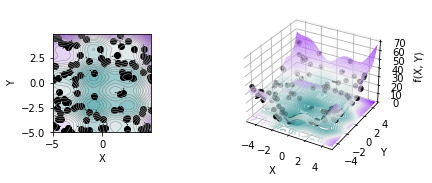

In [30]:
pso_1 = PSO(particles.copy(), velocities.copy(), fitness_function,w=0.1,\
           c_1=4.0,c_2=0.0,auto_coef=True)

fig = plt.figure()
while pso_1.next():
    fig.clear()
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    plot_3d_pso(meshgrid, f, pso_1.particles, pso_1.velocities, ax=ax)
    ax = fig.add_subplot(1,3,1)
    plot_2d_pso(meshgrid, f, pso_1.particles, pso_1.velocities,ax=ax)
    
    plt.show()

In [31]:
str(pso_1)

'[100/100] $w$: 0.400 - $c_1$: 0.530 - $c_2$:3.470'